# Predicting E-Commerce Product Recommendations from Reviews - Sentiment Analysis


# Load up basic dependencies

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow_hub as hub
import nltk
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [2]:
!pip install contractions
!pip install textsearch
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 9.6 MB/s eta 0:00:00


# Load and View the Dataset

The data is available at https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews from where you can download it.

In [3]:
df = pd.read_csv('https://github.com/dipanjanS/text-analytics-with-python/raw/master/media/Womens%20Clothing%20E-Commerce%20Reviews%20-%20NLP.csv', keep_default_na=False)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


# Data Processing


In [4]:
df['Review'] = (df['Title'].map(str) +' '+ df['Review Text']).apply(lambda row: row.strip())
df['Recommended'] = df['Recommended IND']
df = df[['Review', 'Recommended']]
df.head()

,Review,Recommended
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,Some major design flaws I had such high hopes ...,0
3,"My favorite buy! I love, love, love this jumps...",1
4,Flattering shirt This shirt is very flattering...,1


## Remove all records with no review text

In [5]:
df = df[df['Review'] != '']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22642 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review       22642 non-null  object
 1   Recommended  22642 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 530.7+ KB


## There is some imbalance in the data based on product recommendations

In [6]:
df['Recommended'].value_counts()

1    18541
0     4101
Name: Recommended, dtype: int64

# Build train and test datasets

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Recommended']), df['Recommended'], test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((15849, 1), (6793, 1))

In [8]:
from collections import Counter
Counter(y_train), Counter(y_test)

(Counter({1: 12966, 0: 2883}), Counter({1: 5575, 0: 1218}))

In [9]:
X_train.head(3)

,Review
4654,Sexy and flows I love this jumpsuit! i'm usual...
5333,Wanted to love it The dresss is much shorter t...
22502,So cute! though inside not soft I got the crea...


In [10]:
y_train[:3]

4654     1
5333     0
22502    1
Name: Recommended, dtype: int64

# Text Pre-processing and Wrangling

We do minimal text pre-processing here given we will be building deep learning models.

In [11]:
import nltk
import contractions
import re
import tqdm


def normalize_document(doc):
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = contractions.fix(doc)
    doc = re.sub(r'[^a-zA-Z\s]', ' ', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()

    return doc

def normalize_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        norm_doc = normalize_document(doc)
        norm_docs.append(norm_doc)

    return norm_docs


In [12]:
X_train['Clean Review'] = normalize_corpus(X_train['Review'].values)
X_test['Clean Review'] = normalize_corpus(X_test['Review'].values)

100%|██████████| 6793/6793 [00:00<00:00, 16959.71it/s]


In [13]:
X_train.drop(columns=['Review'], inplace=True)
X_test.drop(columns=['Review'], inplace=True)

In [14]:
X_train_f, X_val, y_train_f, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train_f.shape, X_val.shape

((12679, 1), (3170, 1))

In [ ]:
X_train_f.head()

,Clean Review
8104,get it love this ordered it on sale but i real...
20009,it is a big beautiful sweater without seeing t...
4507,just great if they still have your size grab i...
16170,simple and classic i purchased this in the cre...
1333,cute shirt but not for me the blue lace with t...


# Experiment 1: Train Classfier with CNN + FastText Embeddings & Evaluate Performance on Test Data


In [16]:
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
t.fit_on_texts(X_train_f['Clean Review'])
t.word_index['<PAD>'] = 0

In [17]:
print(max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]),
      min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]),
      t.word_index['<UNK>'])

('sadl', 10989) ('<PAD>', 0) 1


In [18]:
max(t.word_index.values())

10989

In [19]:
train_sequences = t.texts_to_sequences(X_train_f['Clean Review'])
val_sequences = t.texts_to_sequences(X_val['Clean Review'])
test_sequences = t.texts_to_sequences(X_test['Clean Review'])

In [20]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=10990
Number of Documents=12679


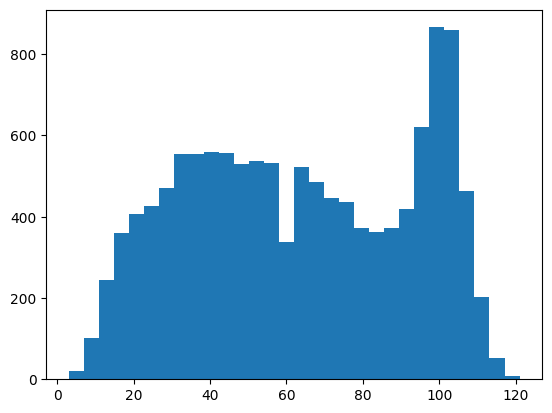

In [21]:
plt.hist([len(doc.split()) for doc in X_train_f['Clean Review']], bins=30);

In [22]:
a = [len(doc.split()) for doc in X_train_f['Clean Review']]
len(a)

12679

In [23]:
max(a)

121

In [24]:
X_train_f[['Clean Review']].iloc[0]

Clean Review    get it love this ordered it on sale but i real...
Name: 8104, dtype: object

In [25]:
MAX_SEQUENCE_LENGTH = 122

X_train_f_seq = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_val_seq = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test_seq = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train_f_seq.shape, X_test_seq.shape

((12679, 122), (6793, 122))

In [26]:
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 300
EPOCHS=10
BATCH_SIZE=32

In [27]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2024-03-29 14:56:07--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.18.87, 13.35.18.15, 13.35.18.103, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.18.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M   133MB/s    in 6.9s    

2024-03-29 14:56:15 (93.8 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [28]:
!unzip wiki-news-300d-1M.vec.zip

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [29]:
word2idx = t.word_index
FASTTEXT_INIT_EMBEDDINGS_FILE = './wiki-news-300d-1M.vec'

In [30]:
def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):

    def get_coefs(word,*arr):
        return word, np.asarray(arr, dtype='float32')

    embeddings_index = dict(get_coefs(*row.split(" "))
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore')
                                    if len(row)>100)

    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))

    for word, idx in word_to_index.items():
        if idx >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [31]:
ft_embeddings = load_pretrained_embeddings(word_to_index=word2idx,
                                           max_features=VOCAB_SIZE,
                                           embedding_size=EMBED_SIZE,
                                           embedding_file_path=FASTTEXT_INIT_EMBEDDINGS_FILE)
ft_embeddings.shape

(10990, 300)

In [32]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 122, 300)          3297000   
                                                                 
 conv1d (Conv1D)             (None, 122, 256)          307456    
                                                                 
 max_pooling1d (MaxPooling1  (None, 61, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 61, 128)           131200    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 30, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 30, 64)            3

In [33]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_f), y=y_train_f)
class_weights

array([2.7325431 , 0.61197992])

In [34]:
dict_class_weights=dict(enumerate(class_weights))

In [35]:
model.fit(X_train_f_seq, y_train_f,
          validation_data=(X_val_seq, y_val),
          epochs=5,
          batch_size=BATCH_SIZE,
          shuffle=True,
          class_weight=dict_class_weights,
          verbose=1)

Epoch 1/5
397/397 [==============================] - 46s 86ms/step - loss: 0.4441 - accuracy: 0.7330 - val_loss: 0.2862 - val_accuracy: 0.8763
Epoch 2/5
397/397 [==============================] - 17s 43ms/step - loss: 0.2184 - accuracy: 0.9031 - val_loss: 0.3045 - val_accuracy: 0.8830
Epoch 3/5
397/397 [==============================] - 8s 20ms/step - loss: 0.1540 - accuracy: 0.9303 - val_loss: 0.2734 - val_accuracy: 0.8823
Epoch 4/5
397/397 [==============================] - 6s 14ms/step - loss: 0.1032 - accuracy: 0.9569 - val_loss: 0.3370 - val_accuracy: 0.8763
Epoch 5/5
397/397 [==============================] - 6s 16ms/step - loss: 0.0681 - accuracy: 0.9736 - val_loss: 0.3627 - val_accuracy: 0.9028


In [36]:
predictions = model.predict(X_test_seq, batch_size=2048, verbose=0).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in predictions]
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75      1218
           1       0.95      0.94      0.94      5575

    accuracy                           0.91      6793
   macro avg       0.84      0.86      0.85      6793
weighted avg       0.91      0.91      0.91      6793



,0,1
0,940,278
1,337,5238


# Experiment 2: Train Classfier with LSTM + FastText Embeddings & Evaluate Performance on Test Data

__Note:__ Skip FastText Embeddings part if it takes too much time to download or load it since it does consume a good amount of memory to load the pretrained embeddings.

## BIDIRECTIONAL LSTM

In [ ]:
EMBEDDING_DIM = 300 
LSTM_DIM = 128 


model2 = tf.keras.models.Sequential()

model2.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE,
                                    output_dim=EMBEDDING_DIM,
                                    input_length=MAX_SEQUENCE_LENGTH),
                                    )

model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))) # to use bidirectional lstms

#model2.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))

model2.add(tf.keras.layers.Dense(256, activation='relu'))

model2.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model2.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 122, 300)          3297000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               439296    
 onal)                                                           
                                                                 
 dense_25 (Dense)            (None, 256)               65792     
                                                                 
 dense_26 (Dense)            (None, 1)                 257       
                                                                 
Total params: 3802345 (14.50 MB)
Trainable params: 3802345 (14.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model2.fit(X_train_f_seq, y_train_f,
          validation_data=(X_val_seq, y_val),
          epochs=5,
          batch_size=BATCH_SIZE,
          shuffle=True,
          class_weight=dict_class_weights,
          verbose=1)

Epoch 1/5
397/397 [==============================] - 59s 71ms/step - loss: 0.4177 - accuracy: 0.8097 - val_loss: 0.2793 - val_accuracy: 0.8804
Epoch 2/5
397/397 [==============================] - 14s 36ms/step - loss: 0.2587 - accuracy: 0.8835 - val_loss: 0.3456 - val_accuracy: 0.8356
Epoch 3/5
397/397 [==============================] - 10s 24ms/step - loss: 0.1790 - accuracy: 0.9257 - val_loss: 0.3313 - val_accuracy: 0.8609
Epoch 4/5
397/397 [==============================] - 11s 27ms/step - loss: 0.1268 - accuracy: 0.9457 - val_loss: 0.3619 - val_accuracy: 0.8454
Epoch 5/5
397/397 [==============================] - 10s 26ms/step - loss: 0.1141 - accuracy: 0.9527 - val_loss: 0.4217 - val_accuracy: 0.8662


In [ ]:
predictions = model2.predict(X_test_seq, batch_size=2048, verbose=0).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in predictions]
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.62      0.77      0.69      1218
           1       0.95      0.90      0.92      5575

    accuracy                           0.87      6793
   macro avg       0.78      0.83      0.80      6793
weighted avg       0.89      0.87      0.88      6793



,0,1
0,936,282
1,568,5007


## UNIDIRECTIONAL LSTM

In [ ]:
model3 = tf.keras.models.Sequential()

model3.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE,
                                    output_dim=EMBEDDING_DIM,
                                    input_length=MAX_SEQUENCE_LENGTH),
                                    )

model3.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))

model3.add(tf.keras.layers.Dense(256, activation='relu'))

model3.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model3.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 122, 300)          3297000   
                                                                 
 lstm_3 (LSTM)               (None, 128)               219648    
                                                                 
 dense_27 (Dense)            (None, 256)               33024     
                                                                 
 dense_28 (Dense)            (None, 1)                 257       
                                                                 
Total params: 3549929 (13.54 MB)
Trainable params: 3549929 (13.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model3.fit(X_train_f_seq, y_train_f,
          validation_data=(X_val_seq, y_val),
          epochs=5,
          batch_size=BATCH_SIZE,
          shuffle=True,
          class_weight=dict_class_weights,
          verbose=1)

Epoch 1/5
397/397 [==============================] - 38s 84ms/step - loss: 0.3974 - accuracy: 0.8009 - val_loss: 0.4553 - val_accuracy: 0.8271
Epoch 2/5
397/397 [==============================] - 9s 24ms/step - loss: 0.2483 - accuracy: 0.8904 - val_loss: 0.3475 - val_accuracy: 0.8603
Epoch 3/5
397/397 [==============================] - 6s 14ms/step - loss: 0.1856 - accuracy: 0.9181 - val_loss: 0.3906 - val_accuracy: 0.8555
Epoch 4/5
397/397 [==============================] - 7s 18ms/step - loss: 0.1613 - accuracy: 0.9282 - val_loss: 0.3889 - val_accuracy: 0.8776
Epoch 5/5
397/397 [==============================] - 8s 20ms/step - loss: 0.1200 - accuracy: 0.9489 - val_loss: 0.3485 - val_accuracy: 0.8823


In [ ]:
predictions = model3.predict(X_test_seq, batch_size=2048, verbose=0).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in predictions]
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.66      0.77      0.71      1218
           1       0.95      0.91      0.93      5575

    accuracy                           0.89      6793
   macro avg       0.80      0.84      0.82      6793
weighted avg       0.90      0.89      0.89      6793



,0,1
0,940,278
1,495,5080


# Experiment 3: Train Classfier with NNLM Universal Embedding Model


In [ ]:
X_testt = X_test['Clean Review'].tolist()

In [ ]:
model4 = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(model4, output_shape=[128], input_shape=[],
                           dtype=tf.string, trainable=True)
print(hub_layer(np.array(X_testt)[:1]))

tf.Tensor(
[[ 1.3196462  -0.02502328  0.15491804 -0.01046132  0.13821559  0.14027943
  -0.04320345 -0.11607114 -0.13772427  0.34843934 -0.06446488 -0.20650537
  -0.33912545 -0.1917886  -0.20643592  0.01692407 -0.2357209   0.00447106
  -0.33513704  0.6621096   0.21141557  0.04193815 -0.08194465 -0.12509024
   0.15659474 -0.12644978  0.2713732  -0.09171303  0.05619222  0.11011251
   0.03915678  0.1234672  -0.02010995 -0.02669094  0.26193377 -0.05183477
  -0.16055904 -0.2878872   0.03010652  0.21635373 -0.2845068  -0.06238906
  -0.18398114  0.02156614  0.17781995  0.24303171  0.0039904   0.06065271
   0.00273594  0.09625956  0.07078222 -0.07288692 -0.16566345  0.12470184
  -0.17580879 -0.11435124  0.13687545 -0.18764065  0.03387763 -0.27904966
  -0.14293237  0.17034708  0.14937723 -0.3784368  -0.10754622  0.13018665
  -0.31221664 -0.16587745  0.14957006  0.06476023 -0.0536939  -0.03869107
  -0.02973461 -0.3864243   0.01321318  0.03010032 -0.37677842 -0.38985074
   0.05399974 -0.10251103 -

In [ ]:
model4 = tf.keras.models.Sequential()

model4.add(hub_layer)

model4.add(tf.keras.layers.Dense(128, activation='relu'))
model4.add(tf.keras.layers.Dropout(0.25))
model4.add(tf.keras.layers.Dense(128, activation='relu'))
model4.add(tf.keras.layers.Dropout(0.25))

model4.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model4.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_10 (KerasLayer  (None, 128)               124642688 
 )                                                               
                                                                 
 dense_29 (Dense)            (None, 128)               16512     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 128)               16512     
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 1)                 129       
                                                     

In [ ]:
X_train_ff = X_train_f['Clean Review'].tolist()
X_val_f = X_val['Clean Review'].tolist()

In [ ]:
X_val_f[0]

'this is a really nice dress for the money i definitely had to size down i have always taken a in hd in paris tops so i initially ordered a but it was a little too big in the chest area i wear a dd so normally this is not my issue i replaced it with a and it fits great i also have a long torso which can be an issue for me with dresses but this one works on me this is definitely a good dress for taller girls the material is high quality too i am going to wear it to my friend s we'

In [ ]:
model4.fit(X_train_f, y_train_f,
          validation_data=(X_val, y_val),
          epochs=5,
          batch_size=128,
          shuffle=True,
          class_weight=dict_class_weights,
          verbose=1)

Epoch 1/5
100/100 [==============================] - 19s 138ms/step - loss: 0.4437 - accuracy: 0.7846 - val_loss: 0.4444 - val_accuracy: 0.8098
Epoch 2/5
100/100 [==============================] - 10s 104ms/step - loss: 0.2398 - accuracy: 0.8949 - val_loss: 0.2655 - val_accuracy: 0.8912
Epoch 3/5
100/100 [==============================] - 9s 87ms/step - loss: 0.1768 - accuracy: 0.9222 - val_loss: 0.3462 - val_accuracy: 0.8615
Epoch 4/5
100/100 [==============================] - 6s 61ms/step - loss: 0.1455 - accuracy: 0.9384 - val_loss: 0.3006 - val_accuracy: 0.8899
Epoch 5/5
100/100 [==============================] - 6s 62ms/step - loss: 0.1151 - accuracy: 0.9527 - val_loss: 0.3419 - val_accuracy: 0.8785


In [ ]:
predictions = model4.predict(X_test, batch_size=2048, verbose=0).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in predictions]
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.63      0.81      0.71      1218
           1       0.96      0.90      0.93      5575

    accuracy                           0.88      6793
   macro avg       0.79      0.86      0.82      6793
weighted avg       0.90      0.88      0.89      6793



,0,1
0,992,226
1,575,5000


# Experiment 4: Train Classfier with DISTIL BERT

##### Note: You might need to restart the notebook environment on colab after installing the below library


In [38]:
!pip install transformers --ignore-installed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.0/774.0 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.1/142.1 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

##### Note: Run the below cell to get all the pre-processed data again in case you needed to reload the notebook after the above installation

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow_hub as hub
import nltk
import matplotlib.pyplot as plt

df = pd.read_csv('https://github.com/dipanjanS/text-analytics-with-python/raw/master/media/Womens%20Clothing%20E-Commerce%20Reviews%20-%20NLP.csv', keep_default_na=False)
df['Review'] = (df['Title'].map(str) +' '+ df['Review Text']).apply(lambda row: row.strip())
df['Recommended'] = df['Recommended IND']
df = df[['Review', 'Recommended']]
df = df[df['Review'] != '']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Recommended']), df['Recommended'], test_size=0.3, random_state=42)

import nltk
import contractions
import re
import tqdm


def normalize_document(doc):
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', ' ', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()

    return doc

def normalize_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        norm_doc = normalize_document(doc)
        norm_docs.append(norm_doc)

    return norm_docs

X_train['Clean Review'] = normalize_corpus(X_train['Review'].values)
X_test['Clean Review'] = normalize_corpus(X_test['Review'].values)

train_clean_text = X_train['Clean Review']
test_clean_text = X_test['Clean Review']


100%|██████████| 6793/6793 [00:02<00:00, 3352.93it/s]


In [3]:
X_train_f, X_val, y_train_f, y_val = train_test_split(train_clean_text, y_train, test_size=0.2, random_state=42)
X_train_f.shape, X_val.shape

((12679,), (3170,))

In [7]:
import transformers
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

In [8]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [9]:
def create_bert_input_features(tokenizer, docs, max_seq_length):

    all_ids, all_masks = [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):

        tokens = tokenizer.tokenize(doc)

        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)

        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)

        all_ids.append(ids)
        all_masks.append(masks)

    encoded = np.array([all_ids, all_masks])

    return encoded

In [11]:
MAX_SEQ_LENGTH = 122

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inputs = [inp_id, inp_mask]

hidden_state = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')(inputs)[0]
pooled_output = hidden_state[:, 0]

dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)

output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)


model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5,
                                           epsilon=1e-08),
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 bert_input_ids (InputLayer  [(None, 122)]                0         []                            
 )                                                                                                
                                                                                                  
 bert_input_masks (InputLay  [(None, 122)]                0         []                            
 er)                                                                                              
                                                                                                  
 tf_distil_bert_model_1 (TF  TFBaseModelOutput(last_hid   6636288   ['bert_input_ids[0][0]',      
 DistilBertModel)            den_state=(None, 122, 768)   0          'bert_input_masks[0][0]

In [13]:
train_features_ids, train_features_masks = create_bert_input_features(tokenizer, X_train_f,
                                                                      max_seq_length=MAX_SEQ_LENGTH)
val_features_ids, val_features_masks = create_bert_input_features(tokenizer, X_val,
                                                                  max_seq_length=MAX_SEQ_LENGTH)
#test_features = create_bert_input_features(tokenizer, test_reviews, max_seq_length=MAX_SEQ_LENGTH)
print('Train Features:', train_features_ids.shape, train_features_masks.shape)
print('Val Features:', val_features_ids.shape, val_features_masks.shape)

Converting docs to features: 100%|██████████| 3170/3170 [00:03<00:00, 860.98it/s]


Train Features: (12679, 122) (12679, 122)
Val Features: (3170, 122) (3170, 122)


In [15]:
model.fit([train_features_ids,
           train_features_masks], y_train_f,
          validation_data=([val_features_ids,
                            val_features_masks], y_val),
          epochs=5,
          batch_size=128,
          shuffle=True,
          verbose=1)

Epoch 1/5
100/100 [==============================] - 237s 2s/step - loss: 0.3001 - accuracy: 0.8707 - val_loss: 0.2015 - val_accuracy: 0.9164
Epoch 2/5
100/100 [==============================] - 159s 2s/step - loss: 0.1729 - accuracy: 0.9288 - val_loss: 0.1950 - val_accuracy: 0.9174
Epoch 3/5
100/100 [==============================] - 159s 2s/step - loss: 0.1350 - accuracy: 0.9446 - val_loss: 0.1872 - val_accuracy: 0.9224
Epoch 4/5
100/100 [==============================] - 150s 2s/step - loss: 0.1074 - accuracy: 0.9590 - val_loss: 0.2499 - val_accuracy: 0.9227
Epoch 5/5
100/100 [==============================] - 158s 2s/step - loss: 0.0711 - accuracy: 0.9736 - val_loss: 0.2594 - val_accuracy: 0.9183


In [16]:
model.save_weights('distillbert_ft_wts.h5')

In [24]:
test_features_ids, test_features_masks = create_bert_input_features(tokenizer, test_clean_text,
                                                                    max_seq_length=122)
print('Test Features:', test_features_ids.shape, test_features_masks.shape)

Converting docs to features: 100%|██████████| 6793/6793 [00:17<00:00, 380.09it/s]


Test Features: (6793, 122) (6793, 122)


In [25]:
predictions = [1 if pr > 0.5 else 0
                   for pr in model.predict([test_features_ids,
                                            test_features_masks], batch_size=200, verbose=0).ravel()]

print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.76      0.81      0.79      1218
           1       0.96      0.94      0.95      5575

    accuracy                           0.92      6793
   macro avg       0.86      0.88      0.87      6793
weighted avg       0.92      0.92      0.92      6793



,0,1
0,991,227
1,312,5263
